**AUTHORS:** \\
Bennett Bierman \\
Filippo Nardi \\
Jorge Parreño \\
Jaime Martinez \\
Robert Glazer

###Note to Reader:
For readibility purposes we added a section at the end called "5. Addendum" in which we perform further analysis to support come conclusions of the exercises and demonstrate different techniques that could have been used to improve our understanding of the data.

In [ ]:
from IPython.core.display import Image, display

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import random

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 3. Unsupervised Learning with Kernel Methods

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Optical recognition of handwritten digits dataset

The [optical recognition of handwritten digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) is another classic benchmark from the UCI repository. The dataset contains $8\times 8$ matrices obtained processing bitmaps of handwritten digits from preprinted forms.

The original bitmaps are $32\times 32$ pixels. The observations are the result of divinding these bitmaps into nonoverlapping $4\times 4$ and counting the number of black pixels in each block. Therefore observations are rows of integers that take values between 0 and 16. A value of $0$ means the block $4\times 4$ block in that position was a blank block while a value of 16 indicates all the pixels of that block were inked.

There are 10 classes, with class names 0 to 9, each class name refers to the corresponding digit.

Each observation can be regarded as a low resolution image of each original handwritten digit.

In [ ]:
from sklearn.datasets import load_digits

data = load_digits()
X = data['data']
Y = data['target']
print("{0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("{0:d} targets".format(len(Y)))
print("Values of the targets:")
print(np.unique(Y))

1797 observations with 64 columns
1797 targets
Values of the targets:
[0 1 2 3 4 5 6 7 8 9]


## Plot some examples

The function `plot_ten_examples` receives ten rows with observations in argument `X` and their corresponding targets in argument `y` and plots the digits.


In [ ]:
def plot_ten_examples(X,y, score=None):
  nrows = 2
  ncols = 5
  ff,aa = plt.subplots(nrows, ncols,figsize=(12,2))
  ii = 0
  for rr in range(nrows):
    for cc in range(ncols):
      aa[rr][cc].set_axis_off()
      aa[rr][cc].imshow(X[ii].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
      if score is None:
        aa[rr][cc].set_title('Target: {0:d}'.format(y[ii]))
      else:
        aa[rr][cc].set_title('Target: {0:d}, score:{1:.3f}'.format(y[ii], score[ii]))
      ii += 1
  ff.tight_layout()

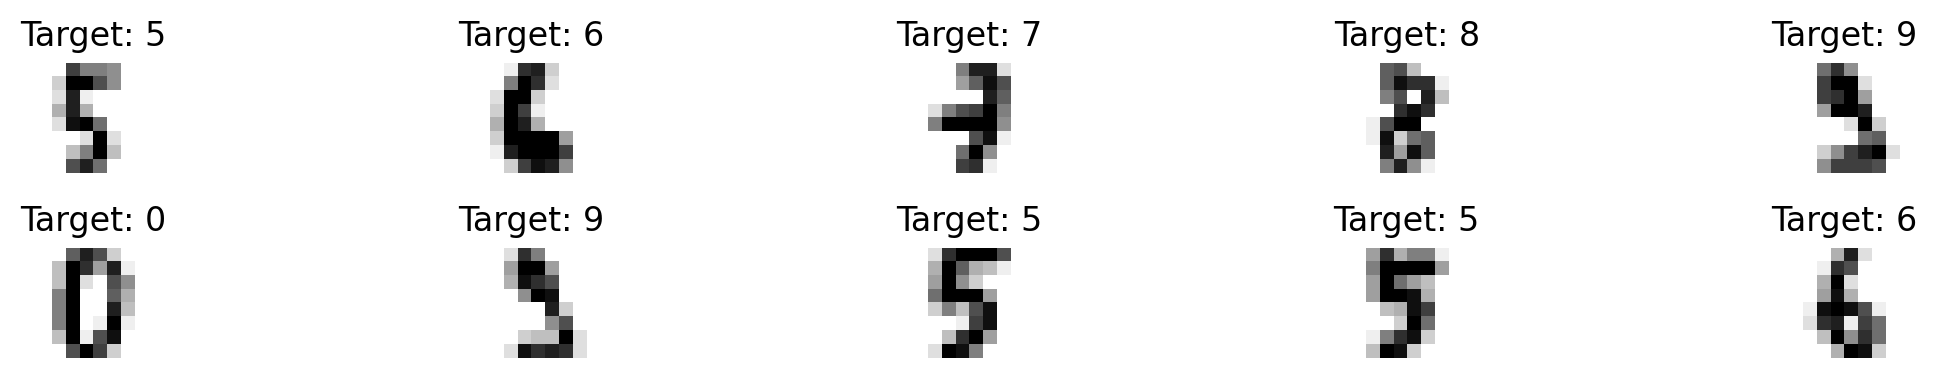

In [ ]:
# plot digits in rows 25 to 34 in X
plot_ten_examples(X[25:35,:],Y[25:35])

## Separation in training and test set

First partition the dataset moving a 50% of the observations to the training set and  and the remaining 50% to the test set.

For simplicity, use the names `X_train, X_test, y_train, y_test` for the corresponding numpy arrays.


In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# 1. Definition of the novelty detection tasks

In this assignment you are going to work with different degrees of supervision in three novelty detection tasks. These novelty detection tasks will be simulated using classification tasks in which we will alter the training set by removing partially or totally the instances of some digits. The test set will be always the same, therefore the novelty stands in the fact that in the test set there will be members of digits that were not present (or very poorly represented) in the training set.


The novelty detections tasks are the following:

1. The training set is formed exclusively by instances of 5. As the test set has instances of all digits, the novelty is the presence of instances of digits different from 5.
2. The training set has no instances of digits 5,6,7,8 and 9. The novelty is the presence of examples of digits 5,6,7,8 and 9 in the test set.

We have prepared two python functions that receive generic training and test set (observations are images of all the digits and targets are integers between 0 and 9) and output the training set observations and labels and the test set labels. Notice the test set observations are always the same.

The functions are `just_fives` and `zero_four`. For example, for the first novelty detection task, where the training set only has instances of digit 5, one should create the corresponing sets using:

`x_train_5, y_train_5, y_test_5, = just_fives(X_train, y_train, y_test, number_novel_instances=0)`

- `x_train_5`: rows of `X_train` that correspond with instances of digit 5. If `number_novel_instances`> 0, there will be some rows in `x_train_5` with instances of other digits.

- `y_train_5`: true binary labels of the rows of `x_train_5` for computing classification scores. If row $i$ of `x_train_5` is an instance of digit 5, then `y_train_5[i]` is 1. Otherwise `y_train_5[i]` is -1.

- `y_test_5`: true binary labels of the rows of `X_test` for computing classification scores. If row $i$ of `X_test` is an instance of digit 5, then `y_test_5[i]` is 1. Otherwise `y_test_5[i]` is -1.

- `number_novel_instances`: number of instances of other digits than 5 in `x_train_5` and `y_train_5`. A value of `number_novel_instances` = $k$ means that the last $k$ rows of `x_train_5` will contain instances of digits different from 5, and therefore the last $k$ elements of `y_train_5` will be -1. Notice $k$ must be smaller than the number of non-five digits in `X_train`.






In [ ]:
def just_fives(x_train, y_train, y_test, number_novel_instances=0):

  is_5 = np.where(y_train==5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = -np.ones(len(y_test), dtype='int')
  yt[y_test==5] = 1


  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)
    is_not_5 = np.where(y_train != 5)[0][my_idx_negs]

    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))


  return xr, yr, yt


def zero_four(x_train, y_train, y_test, number_novel_instances=0):
  is_5 = np.where(y_train < 5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = np.ones(len(y_test), dtype='int')
  yt[y_test>=5] = -1


  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)

    is_not_5 = np.where(y_train >= 5)[0][my_idx_negs]
    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))

  return xr, yr, yt

## 1.1 Evaluation of the performance

In this assignment you will use the **confusion matrix** to evaluate the performance of the methods. The confusion matrix captures all the possible outcomes of a classifier. In a multiclass classification problem with $M$ classes, the confusion matrix is a $M\times M$ matrix $C$ where position $M_{ij}$ counts the number of instances of class $i$ in the test set that were predicted as instances of class $j$ by the classifier. Therefore large numbers in main diagonal of $C$ indicate a successful performance while the elements in off-diagonal positions account for errors.

In a binary classification problem (and the novel detection can be cast as a binary classification setting where the positive class is formed by normal observations and the negative class is formed by the novel observations) each output of the classifier can be categorized in one of these groups:
- True positive (TP): test observations whose true class is the positive one and the classifier correctly classifies

- False negative (FN): test observations whose true class is the positive one but the classifier classifies as negative

- True negative (TN): test observations whose true class is the negative one and the classifier correctly classifies

- False positive (FP): test observations whose true class is the negative one but the classifier classifies as positive.

With this notation the confusion matrix in a binary case is
$$
C = \left [ \begin{array}{cc} TN & FP \\ FN & TP \end{array}\right ]
$$
For normalization purposes, the rows of $C$ add up to the number of test observations in each true class while the columns of $C$ add up to the number of test observations classified to each class.

The confusion matrix is implemented in sklearn in function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

# 2. One-Class SVM for novelty detection.
The first exercise of the assignment consists in to evaluate the capabilities of the sklearn implementation of One-class SVM [One-class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) as novelty detector.

You are using RBF kernels and to avoid tunig the value of $\gamma$ use a value `gamma= "scale"`.

There is a key parameter in the implementation of OneClassSVM called `nu`. This parameter controls the regularization (similar role to $C$) in the sense that `nu` is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval $(0, 1]$. For instance `nu=0.3` means that at least 30% of the training data will become support vectors, that is, they will en up either on the margin (being inliers) or on the wrong side of the margin. Some of the support vectors on the wrong side of the margin will eventually become outliers as they will be also on the wrong side of the classification boundary (in this case the classification boudnary separates inliers from outliers). This is why `nu` can be considered an upper bound for the number of errors.

## 2.1. Training set with only fives case.

First use function `just_fives` to obtain the data corresponding to the task in which there are only instances of 5 in the training set.


In [ ]:
X_train_5, y_train_5, y_test_5 = just_fives(X_train, y_train, y_test,0.)

### 2.1.1 Dependence with `nu`

Complete the code of the following function that will help you study the performance of OneClassSVM in this novelty detection task.

Consider the following range of variation of `nu`:
$$
\mbox{nu } \in \{ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2\}
$$

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

def simulate_oneclasssvm_nu(x_train, x_test, y_train, y_test, range_nu):
  tn = np.empty(len(range_nu)) # true negatives for every value of nu
  fp = np.empty(len(range_nu)) # false positives for every value of nu
  fn = np.empty(len(range_nu)) # false negatives for every value of nu
  tp = np.empty(len(range_nu)) # true positives for every value of nu

  """
  YOUR CODE

  Implement a loop that iterates over the values of range_nu. For each iteration
  1. instantiate a OneClassSVM with the value of nu fixed to one that corresponds
    to the current iteration
  2. train the OneClassSVM with x_train and y_train
  3. predict the outlier or inlier condition for the rows of x_test
  4. call confusion_matrix to obtain TN, FP, FN, TP and fill the corresponding
     position of arrays tn, fp, fn and tp
  """

  for i, nu_value in enumerate(range_nu):
    model = OneClassSVM(kernel="rbf", gamma="scale", nu=nu_value)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    tn[i], fp[i], fn[i], tp[i] = confusion_matrix(y_test, y_pred).ravel()

  return tn, fp, fn, tp

#### Plot the dependence of the performance with nu

Call `simulate_oneclasssvm_nu` with the outcome of `just_fives` and plot the evolution of true negatives, false positives, false negatives and true positives in the novelty detection as `nu` varies.

Discuss:
- What is the method better at?
  - detecting 5s in the test set
  - detecting novelties in the test set

- How is the variation of the performance with `nu`? Any explanation?

Hint: use logarithmic scale in the x-axis, to better accommodate the selected range for `nu`

In [ ]:
nu_range = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

def plot_diff_nus(tn, fp, fn, tp):
  plt.figure(figsize=(10, 6))
  plt.semilogx(nu_range, tn, label="True Negatives (TN)")
  plt.semilogx(nu_range, fp, label="False Positives (FP)")
  plt.semilogx(nu_range, fn, label="False Negatives (FN)")
  plt.semilogx(nu_range, tp, label="True Positives (TP)")
  plt.xlabel("nu")
  plt.ylabel("Count")
  plt.title("Performance of One-Class SVM with Different nu Values")
  plt.legend()
  plt.grid()
  plt.show()

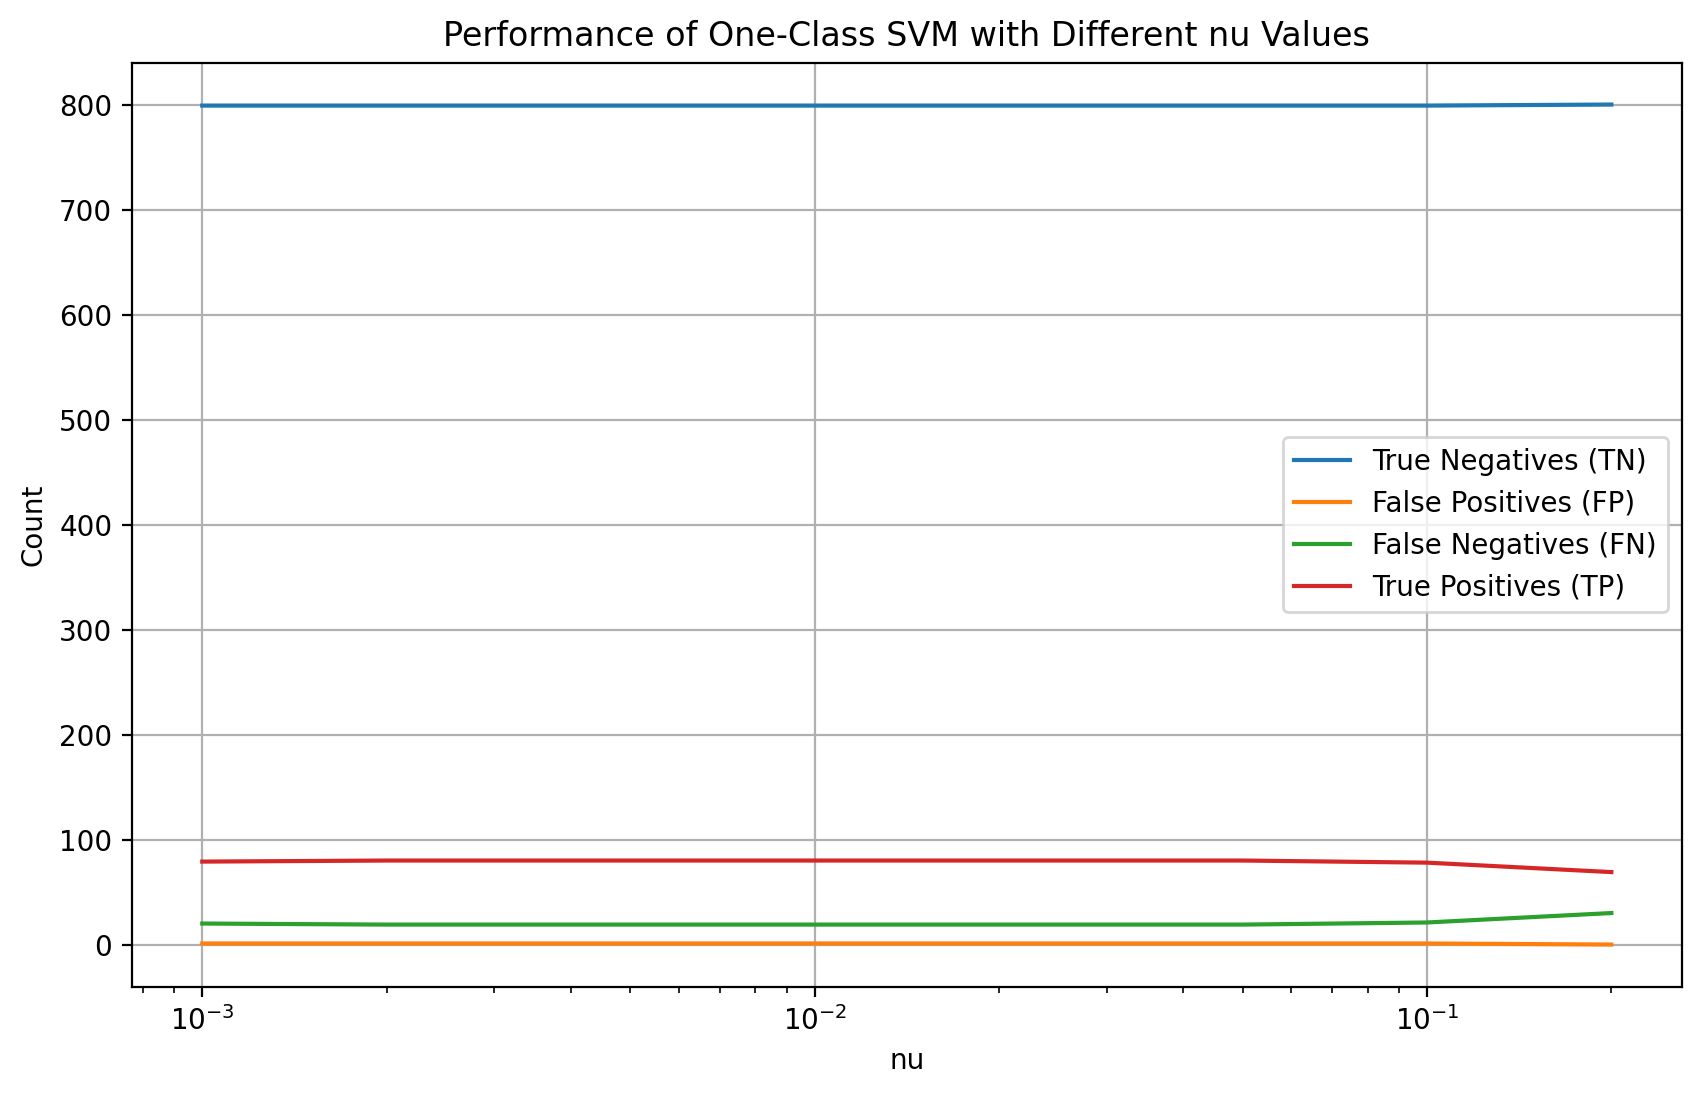

In [ ]:
tn_5, fp_5, fn_5, tp_5 = simulate_oneclasssvm_nu(X_train_5, X_test, y_train_5, y_test_5, nu_range)
plot_diff_nus(tn_5, fp_5, fn_5, tp_5)

**Your discussion**

The model performs succintly better at detecting instances of the negative class, as there are virtually no false positives, i.e., the model performs much better at detecting non-5s.

A slight decrease in the quality of the predictions is observed for values of $\nu > 10^{-1}$, which is reflected in an increase in the false negatives, that is it begins to commit more error when crossing that threshold value.

We proceed by plotting the per class recall, to observe the sensitivity of the classifier to each label and in order to provide an insightful visual tool to assess the quality of our binary classifier.

In [ ]:
def sensitivities(xr, yr, yt):
  tn, fp, fn, tp = simulate_oneclasssvm_nu(xr, X_test, yr, yt, nu_range)
  fnr = fn / (fn + tn)
  fpr = fp / (tp + fp)
  plt.semilogx(nu_range, fnr, label='False Negative Rate (FNR)')
  plt.semilogx(nu_range, fpr, label='False Positive Rate (FPR)')
  plt.xlabel('nu')
  plt.ylabel('Rate')
  plt.grid()
  plt.title('False Negative Rate (FNR) and False Positive Rate (FPR) vs. nu')
  plt.legend()
  plt.show()
  return fnr, fpr

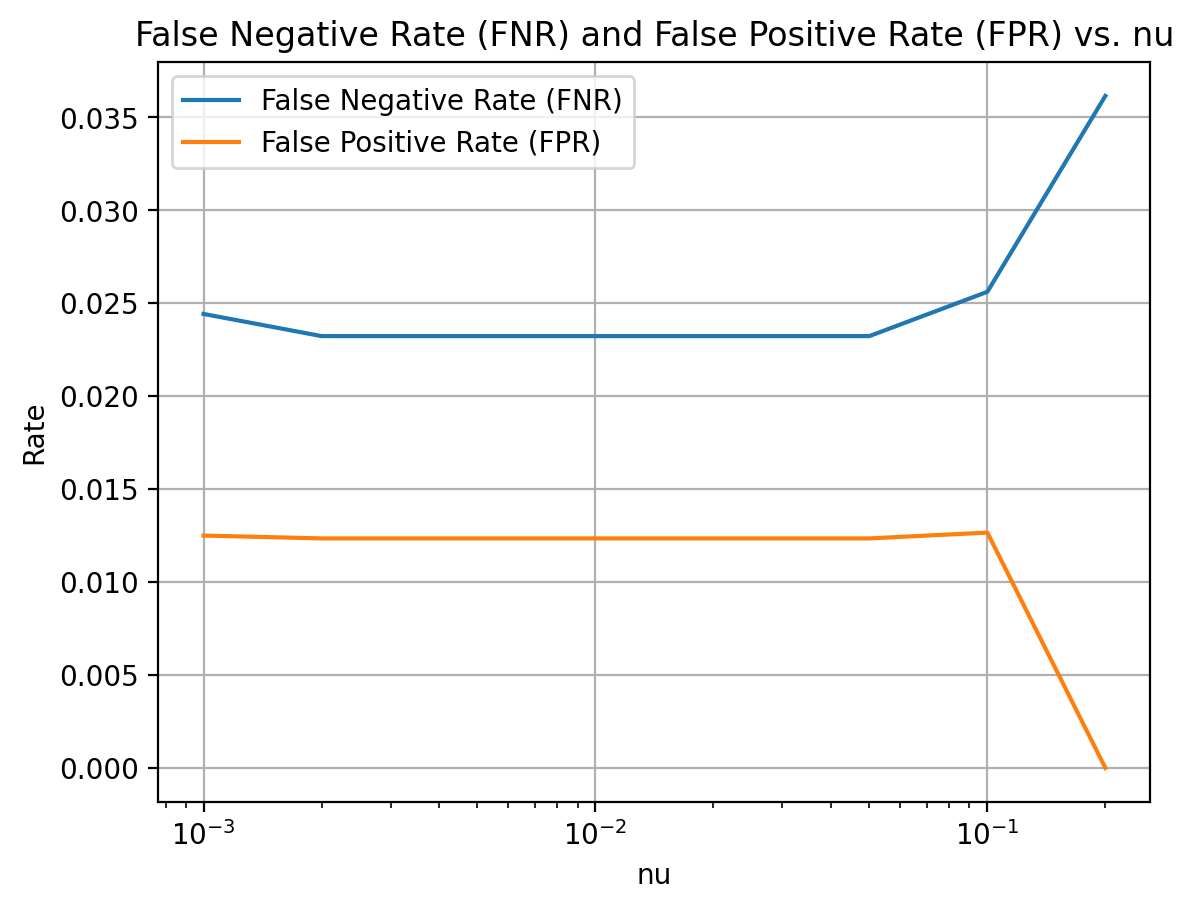

In [ ]:
fnr_5, fpr_5 = sensitivities(X_train_5, y_train_5, y_test_5)

This visualization further supports our assessment of the performance of our novelty detector, having more false negatives means having more instances of 5s that are misclassified.

Since performance is captured by the notions of FPR (False Positive Rate) and FNR (False Negative Rate), we choose the Nus that minimize this two values and consider both options. In fact, we can only focus in the False Positive Rate, since we can categorize the outliers as being non-5 instances

### 2.1.2 Qualitative analysis

Select a value of `nu` with good performance, train a OneClassSVM with the outcome of `just_fives` and obtain the score (real valued ouput, not label) for the test set observations.

Use the function `plot_ten_examples` to plot the 5 observations with the highest score and the 5 observations with the lowest score within the test observations whose true class is 5.

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

def show_best_and_worst(g_nu, xr, yr, yt, is_pos=True):

  # Train model and create scores
  model = OneClassSVM(kernel="rbf", gamma="scale", nu=g_nu)
  model.fit(xr, yr)
  scores = model.decision_function(X_test)

  # Filter data
  class_idxs = (yt == 1) if is_pos else (yt == -1)
  scores_c = scores[class_idxs]
  X_test_c, y_test_c = X_test[class_idxs], yt[class_idxs]
  sorted_idxs = np.argsort(scores_c)
  low_idxs, high_idxs = sorted_idxs[:5][::-1], sorted_idxs[-5:][::-1]

  # Find highest and lowest scoring Observations
  obs = np.concatenate((X_test_c[high_idxs], X_test_c[low_idxs]))
  y_s = np.concatenate((y_test_c[high_idxs], y_test_c[low_idxs]))
  score_s = np.concatenate((scores_c[high_idxs], scores_c[low_idxs]))

  # Plot Observations
  plot_ten_examples(obs, y_s, score_s)

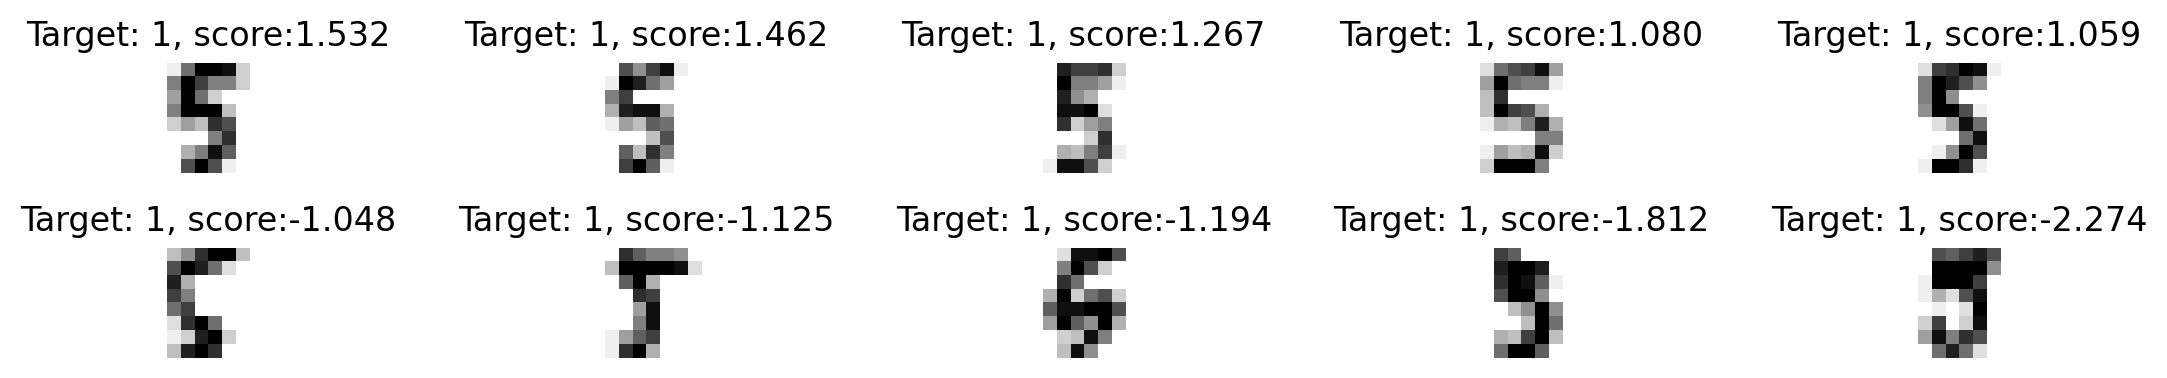

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

# Choose nu value
nu_idx = np.argmin(fpr_5)
good_nu = nu_range[nu_idx]

# Find values for part 3
tn_b, fp_b, fn_b, tp_b =  tn_5[nu_idx], fp_5[nu_idx], fn_5[nu_idx], tp_5[nu_idx]

# Plot figures
show_best_and_worst(good_nu, X_train_5, y_train_5, y_test_5)

Do the same plot with the observations in the test set whose true class is not 5

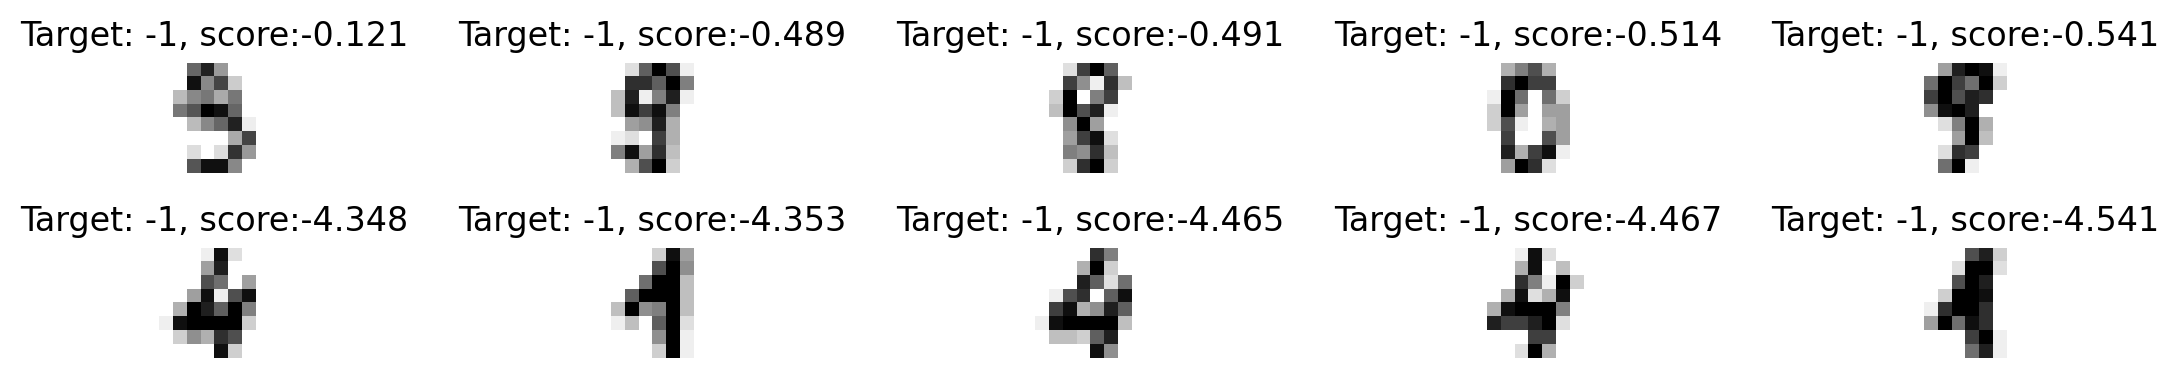

In [ ]:
#############
#           #
# YOUR CODE #
#           #
#############

show_best_and_worst(good_nu, X_train_5, y_train_5, y_test_5, is_pos=False)

**Comment on the aspect of these examples. Do the negative examples with the highest score look like 5s?**

Definitely, since the first two examples with the highest scores might resemble a five, according to the countour of the pixelated images and specially comparing it with the first of the pictures above


**How are the scores of the negative examples that achieved the highest scores compared with the scores of the positive examples that achieved the lowest scores?**

Taking a look onto the previous two generated outcomes, we can compare the scores, and after extracting them, we can see that the lowest scores of the positive examples get a significantly lower score than the highest scores of the negative examples, despite the fact that the image of a five can be more easily perceived on the positive examples while having a lower score

## 2.2. Training set without 5, 6, 7, 8, and 9.

First use function `zero_four` to obtain the data corresponding to the task in which there are no instances of 5, 6, 7, 8 and 9 in the training set.


In [ ]:
X_train_04, y_train_04, y_test_04 = zero_four(X_train, y_train, y_test,0.)

### 2.2.1 Dependence with `nu`

Repeat step 2.1.1 with this novelty detection task data.


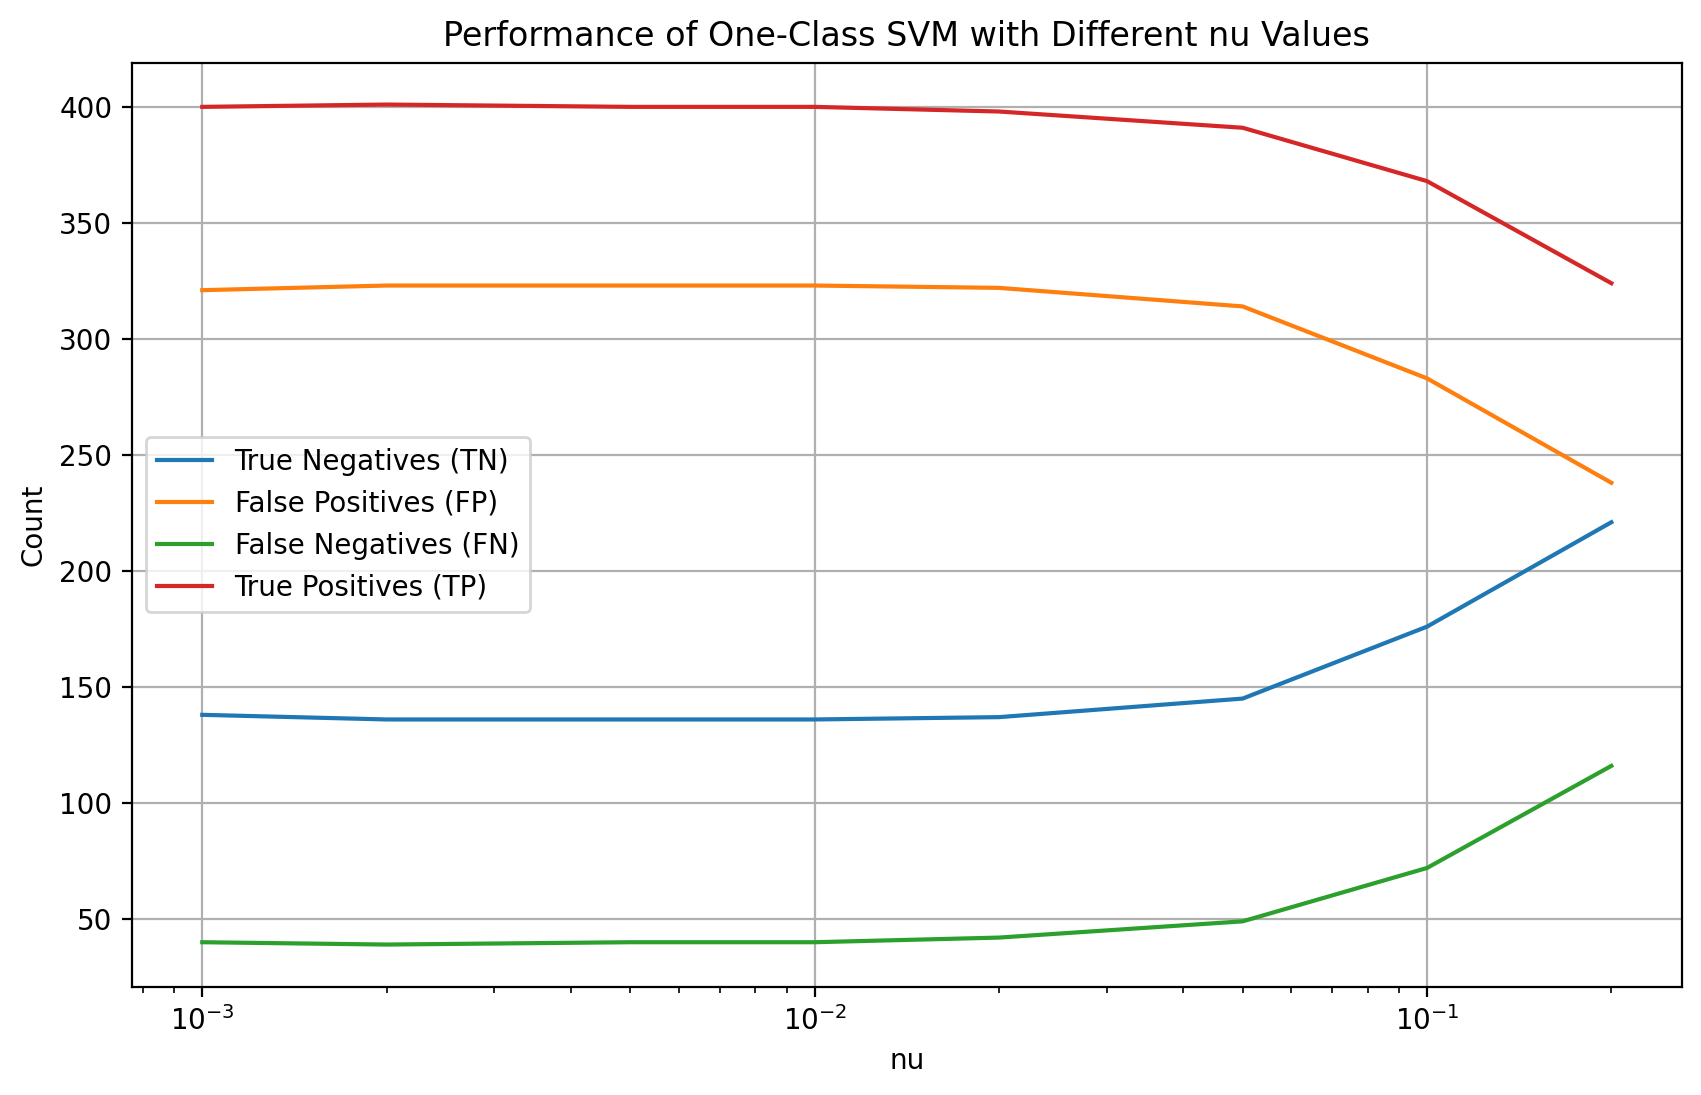

In [ ]:
#############
# YOUR CODE #
#############

tn_04, fp_04, fn_04, tp_04 = simulate_oneclasssvm_nu(X_train_04, X_test, y_train_04, y_test_04, nu_range)
plot_diff_nus(tn_04, fp_04, fn_04, tp_04)

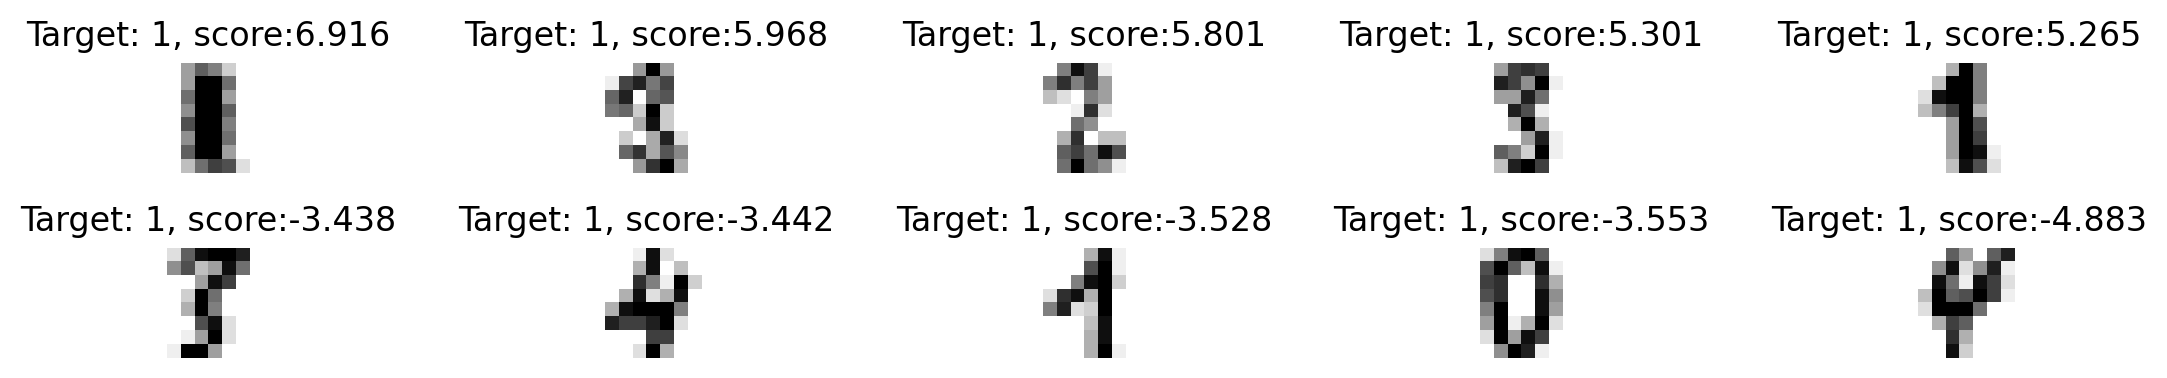

In [ ]:
show_best_and_worst(good_nu, X_train_04, y_train_04, y_test_04)

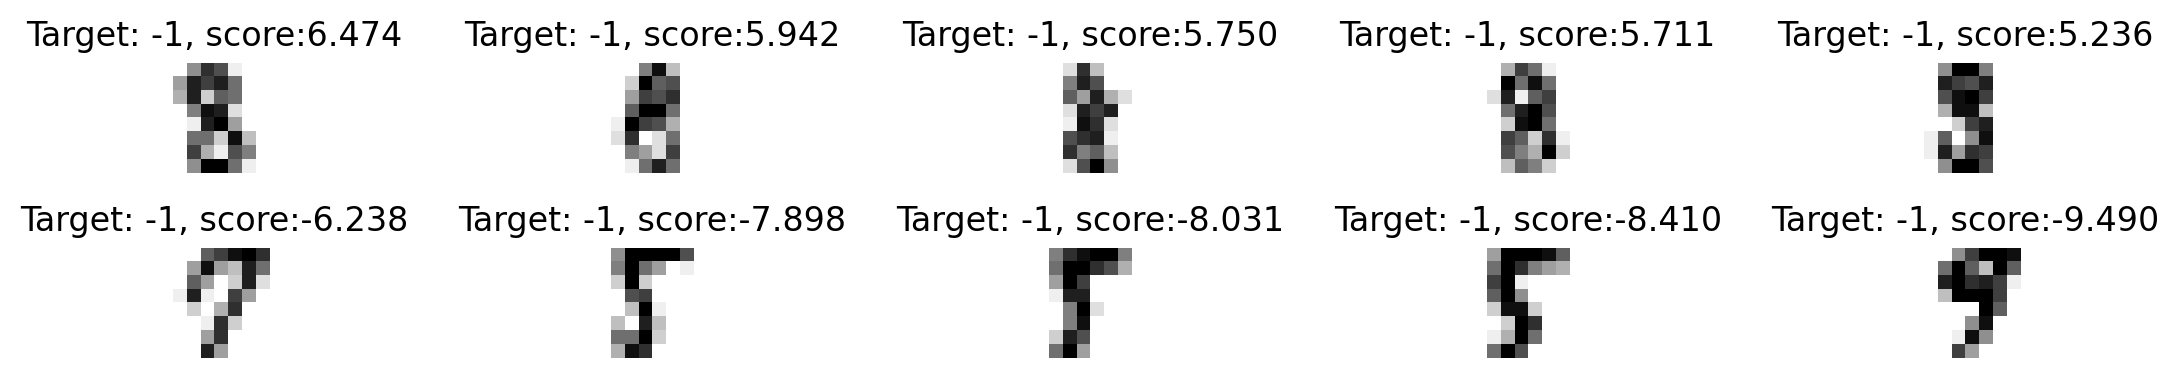

In [ ]:
show_best_and_worst(good_nu, X_train_04, y_train_04, y_test_04, is_pos=False)

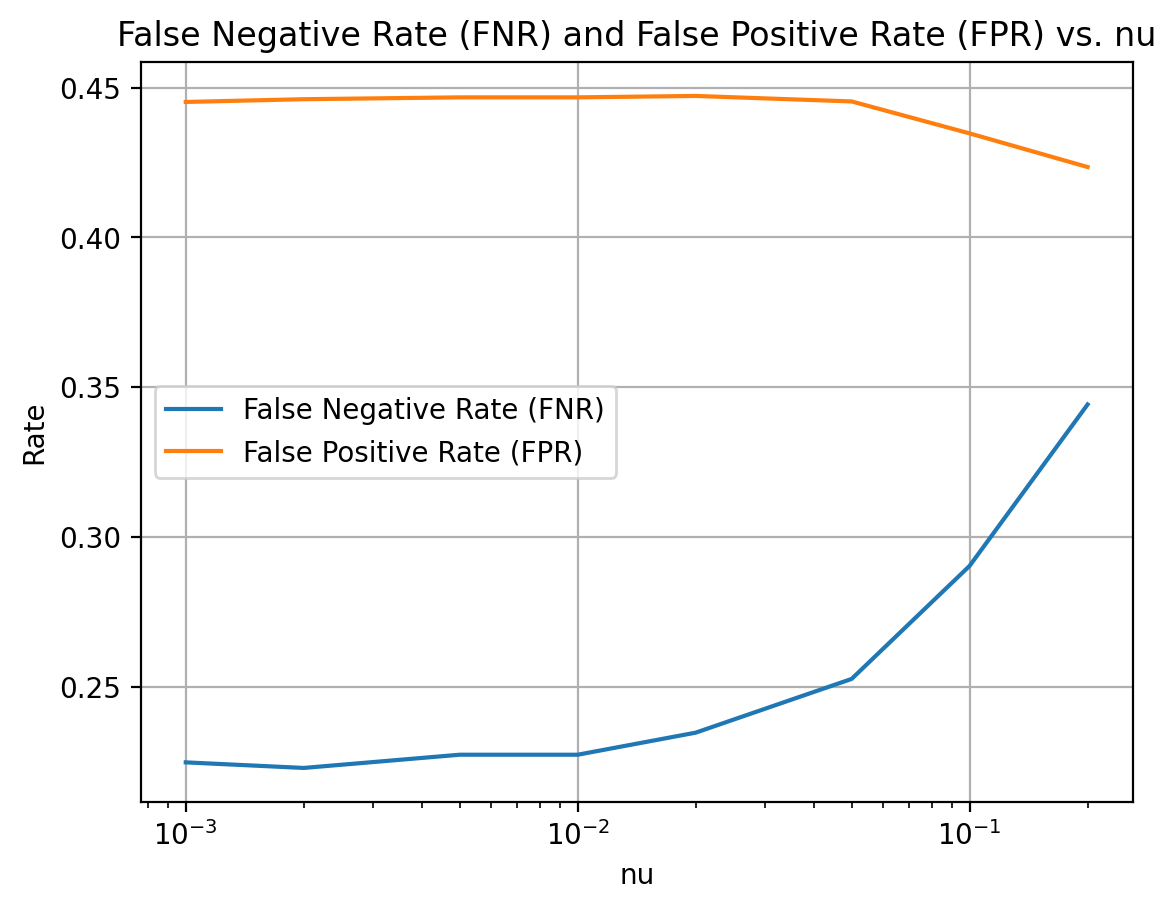

In [ ]:
fnr_04, fpr_04 = sensitivities(X_train_04, y_train_04, y_test_04)

In [ ]:
nu_idx_04 = np.argmin(fpr_04)
tn_f, fp_f, fn_f, tp_f =  tn_04[nu_idx_04], fp_04[nu_idx_04], fn_04[nu_idx_04], tp_04[nu_idx_04]

**Discussion. Comment on the differences in performance with the other two tasks.**

Since the cardinality of the set we are working now with in the training set ${0, 4}$ is higher than the one when we were working with just fives, it makes sense that the variability is higher since it the posibilities of confusing each instance wth a 5 is lower than to confuse it with any of the numbers in the prevoiusly mentioned set

**This third task is closer to the task training with just 5s or to training without 5s?**

We consider it to be closer to the task training without fives since the amount of possible outcomes is higher which, as previously mentioned, leads to a higher variability, and thus, it performs in a more similar manner


# 3. Introducing supervision
In this part you will explore the advantages of incorporating supervised learning in the form of a few instances of the negative class

Previously complete the code of the function `simulate_svm` that will help you with the experiments of this section.

In [ ]:
from sklearn.svm import SVC

def simulate_svm(x_train, x_test, y_train, y_test, fun, range_number_negatives):
  # fun: function that obtains the data for each novelty detection task.
  #      it can take the values no_fives, just_fives, zero_four.
  #.     And yes, in python functions can receive other functions as arguments
  # range_number_negatives: list with the number of samples in the negative
  #                         class that you want in the training set to simulate
  #                         a novelty detection task with partial supervision

  tn = np.empty(len(range_number_negatives))
  fp = np.empty(len(range_number_negatives))
  fn = np.empty(len(range_number_negatives))
  tp = np.empty(len(range_number_negatives))

  """
  YOUR CODE
  1. create a SVM for classification with RBF kernel, C fixed to 1e4 and a
     value of gamma set to 'scale'
  2. Loop for all the values in range_number_negatives
     2.1 call fun to obtain the data to simulate a partially supervised novelty
         detection task with the number of observations of the negative class in
         the trainining set corresponding to this iteration of the loop
     2.2 train the SVM with the outcome of step 2.1
     2.3 get the class predictions for the test set
     2.4 call confusion_matrix with y_test and the outcome of point 2.3 and
         fill the positions in tn, fp, fn and tp corresponding to this iteration
         of the loop
  """

  model = SVC(kernel='rbf', C=1e4, gamma='scale')

  for i,neg_vals in enumerate(range_number_negatives):
    xr, yr, yt = fun(x_train, y_train, y_test, neg_vals)
    model.fit(xr, yr)
    y_pred = model.predict(x_test)
    tn[i], fp[i], fn[i], tp[i] = confusion_matrix(yt, y_pred).ravel()

  return tn, fp, fn, tp



## 3.1 Supervision in the only 5s task

Obtain a logarithmic range for the values of the number of instances of the negative class (non 5s) in the training set. Use 10 values between 1 and the maximum value equal to the number of non 5s in the training set.

Hint: numpy logspace could serve for this purpose. And remember the elements in the range should be integers...

In [ ]:
#############
# YOUR CODE #
#############

non_5s = X_train[y_train != 5].shape[0]
log_range = np.logspace(0, np.log10(non_5s), num=10, dtype='int')
log_range

array([  1,   2,   4,   9,  19,  41,  87, 183, 386, 814])

Call `simulate_svm` to obtain the variation of TN, FP, FN and TP as the supervision of the problem increases.

Make a plot with the evolution of these 4 performance metrics. To compare with the unsupervised part, in this plot, show with **constant** dashed lines the values for  TN, FP, FN and TP obtained by OneClassSVM with the best value of `nu`.

In [ ]:
#############
# YOUR CODE #
#############

def plot_diff_negs(tns, fps, fns, tps, tng, fpg, fng, tpg):
  plt.figure(figsize=(10, 6))
  plt.semilogx(log_range, tns, label="True Negatives (TN)", color='blue')
  plt.semilogx(log_range, fps, label="False Positives (FP)", color='orange')
  plt.semilogx(log_range, fns, label="False Negatives (FN)", color='green')
  plt.semilogx(log_range, tps, label="True Positives (TP)", color='red')

  plt.axhline(y=tng, linestyle='--', label='Unsupervized TN', color='blue')
  plt.axhline(y=fpg, linestyle='--', label='Unsupervized FP', color='orange')
  plt.axhline(y=fng, linestyle='--', label='Unsupervized FN', color='green')
  plt.axhline(y=tpg, linestyle='--', label='Unsupervized TP', color='red')

  plt.xlabel("# of Negative Training Samples")
  plt.ylabel("Count")
  plt.title("Performance of One-Class SVM with Various Negaitve Training Samples")
  plt.legend()
  plt.grid()
  plt.show()

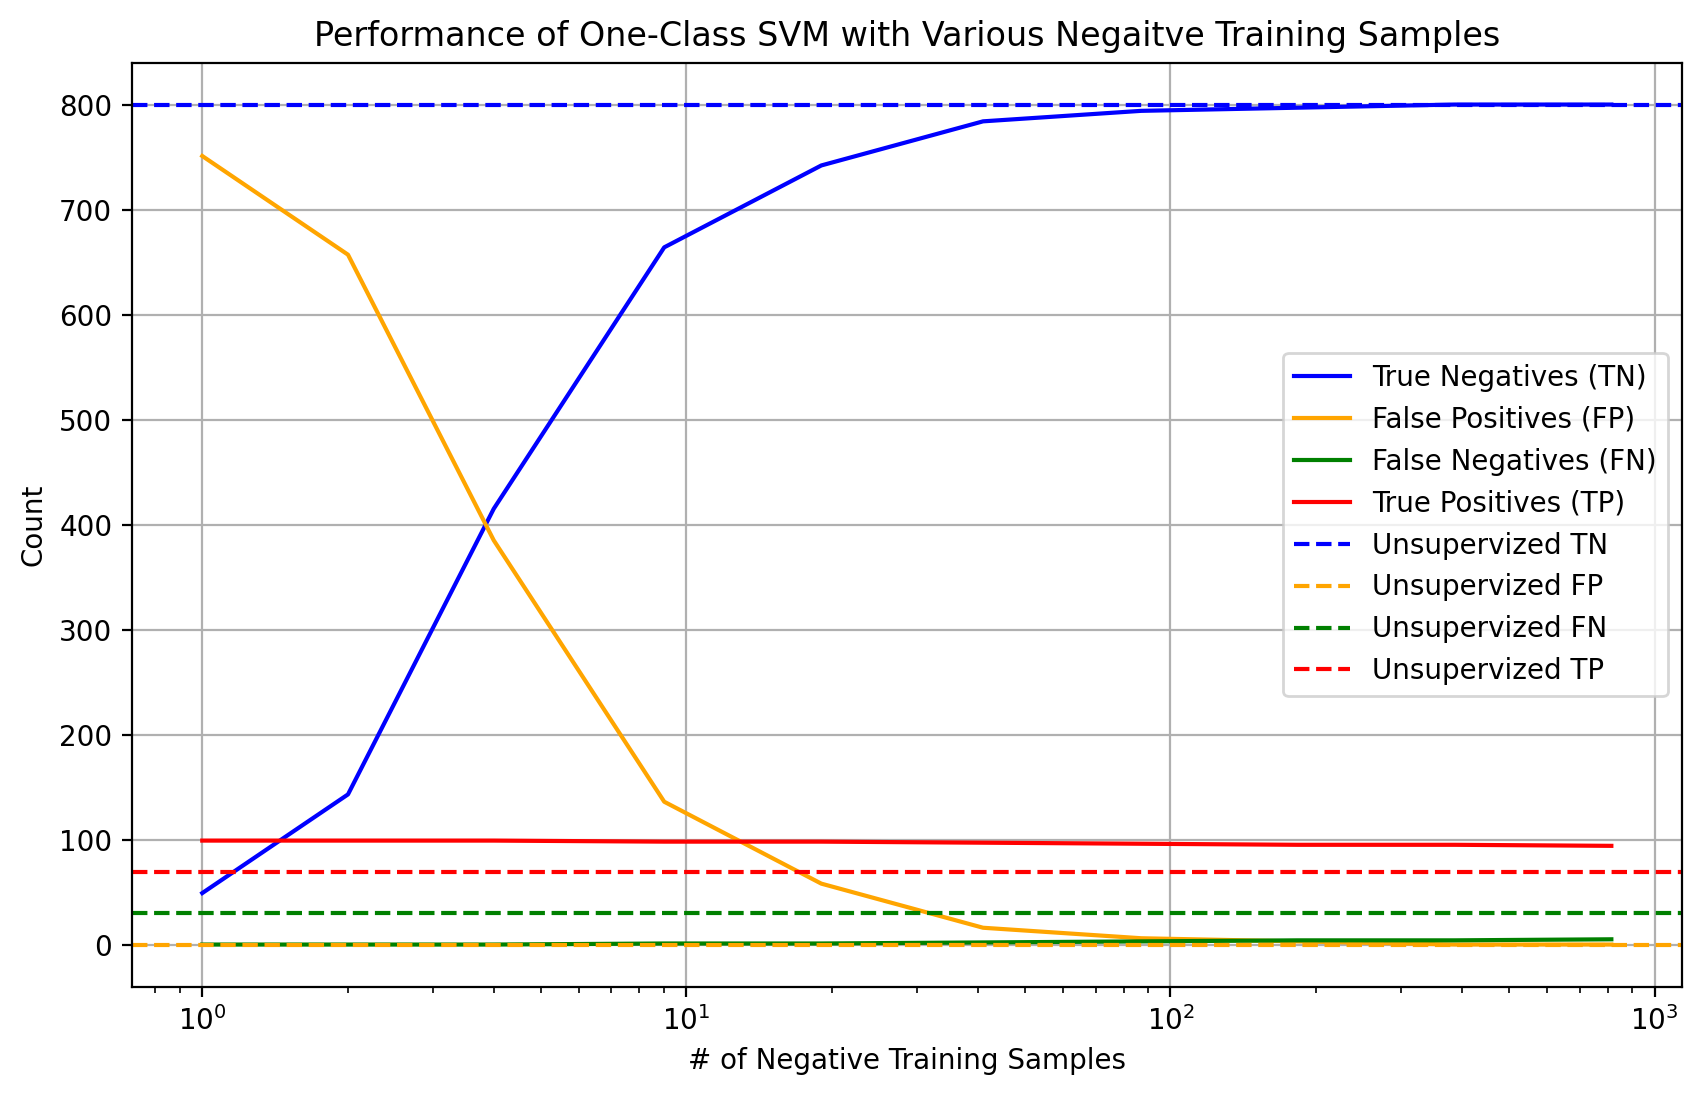

In [ ]:
tn, fp, fn, tp = simulate_svm(X_train, X_test, y_train, y_test, just_fives, log_range)
plot_diff_negs(tn, fp, fn, tp, tn_b, fp_b, fn_b, tp_b)

**Discussion**

Discuss the evolution of the 4 performance magnitudes as the number of negative samples in the training set increases.

Notice the OneClassSVM can be regarded as 0 negative samples. Is there any range of values of negative instances for which in any performance measure the OneClassSVM performs better than the SVM?

A1: When evaluting the performance of One-Class SVM as the  number of negative samples in the training set increases we see that True Negatives (TN) will increase because the model can correctly identify more of the actual negative instances, while False Positives (FP) will decrease as the model becomes more conservative and cautious about labeling instances as positive. In our case we see that True Negatives converge to our unsupervized True negative and our False Positive converges to our unsupervized False Positive

A2: In a binary classification scenario with both positive and negative classes, the One-Class SVM is not expected to perform better than an SVM when we have a sufficient number of negative samples. SVMs are designed for such scenarios, whereas One-Class SVMs are specialized for one-class problems where there are no negative samples in the training set. However when dealing with a high imbalanced dataset, such as for novelty detection, the One-class-SVM may perform better as it's inherently geared towards identifying outliers or unusual data points. This range of negative values could be considered from a  ratio of 1 negative instances for a 100 positive instances, or even more extreme scenarios.

## 3.2 Supervision in the without 5, 6, 7, 8, and 9 task


Repeat section 3.1 but now in the task in which the negative class are digits 5, 6, 7, 8 and 9 and the positive class is formed by digits 0, 1, 2, 3, 4.

Include in you discussion the comparison between the three tasks.

In [ ]:
#############
# YOUR CODE #
#############

geq_5s = X_train[y_train >= 5].shape[0]
log_range_04 = np.logspace(0, np.log10(geq_5s), num=10, dtype='int')
log_range_04

array([  1,   1,   3,   7,  14,  29,  57, 113, 222, 437])

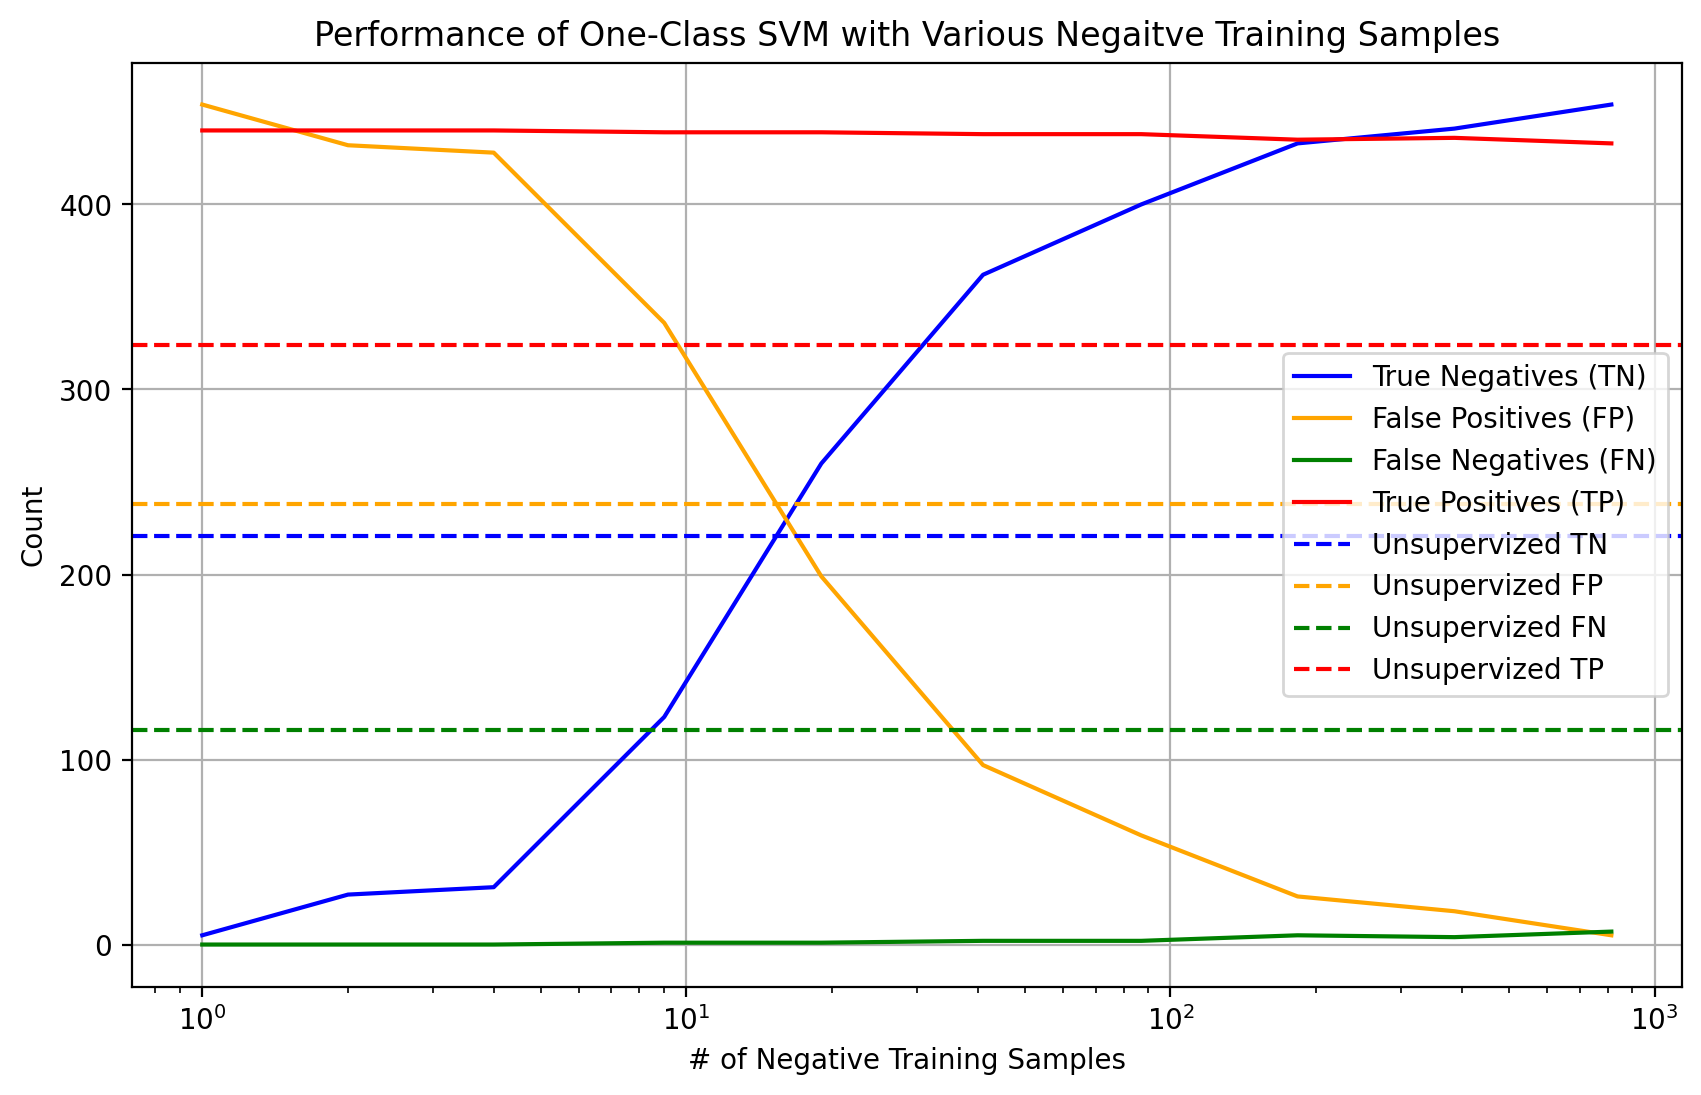

In [ ]:
#############
# YOUR CODE #
#############

tn, fp, fn, tp = simulate_svm(X_train, X_test, y_train, y_test, zero_four, log_range_04)
plot_diff_negs(tn, fp, fn, tp, tn_f, fp_f, fn_f, tp_f)

# 4. Conclusions

- Which of the novelty detection taks is more difficult? A task is more difficult as it is harder to yield good performance

- For each task, which is the amount of supervision (number of negative labelled observations in the training set) that makes SVM outperform OneClassSVM?

- Since we understand a good performance as a low amount of misclassifictions, we are extracting conclusions basing ourselves on the values stored inside the different confusion matrices.

**A1**: The performance is captured by the notion of false positive rate, since it captures the proportion of outliers that are classified as the positive class.

We observed for all values of $\nu$ significantly lower FPR for the task of 0s and 4s, this reflects the better achieved performance in the task.

Another interesting metric is the FNR, where the results support the same conclusion for all values of $\nu$. For  the considered discrete array of $\nu$ values the FNR of the just 5s task is better, however to properly quantify by how much, in a similar manner as for the previous lab, we would need to improve the interpolation of both FNR and FPR, for which devising a scheme of interpolation where the density of values considered could be dynamically adjusted would be preferrable to get a more precise graph.

**A2**:
For the just 5s task, from the graph we infer the following:
 - The true negatives of the supervised case only catch up to the unsupervised case seemingly at $10^{3}$, there seems to be a sort of asymptotic approach.
 - The false positives of the supervised svm, decrease as the number of negative of negative training samples increase, which makes sense since the more instances of the negative class the classifier sees, the less likely it is to misclassify negative instances as positive ones.
 - The false negatives are better for the supervised svm for all amounts of negative training samples.
 - The same holds for the true positives.

For the without 5, 6, 7, 8, and 9 task, we observe the following
 + For even one negative training sample the false negatives are reduced to 0, that stays consistent up until close to $10^{²}$ where there is a slight increase.
 - For negative training samples up to somewhat over 10, the number of false positives for the supervised SVM is lower than that of the unsupervised One-Class svm.
 - For almost the same threshold value, onwards, the true negatives of the supervised svm is better than the unsupervised version.

# 5. Addendum

In this section we performed further exploration into the MNIST dataset using different techniques to provide further support to our answers and improve our understanding of the data.

We first proceed by getting the TSNE (t-stochastic neighbor embedding) representation of our dataset (essentially a lower dimensional one) in order to view the data distribution since we expect that similar labels are grouped together.

TSNE is designed for vectors and since we are working with images we require a procedure to get image embeddings, for which we selected the top part of a known light convolutional neural network architecture like MobileNetV2, since even without training, it is capable of giving meaningful embeddings and cluster similar things together.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import cv2 as cv

In [ ]:
def embed(img, model):
  img = img.astype(np.uint8)
  img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
  img = cv.resize(img, (224, 224), interpolation=cv.INTER_AREA)
  img = np.array(img)
  img = img/255.0
  img = np.expand_dims(img, axis=0)
  embedding = model.predict(img)
  return np.squeeze(embedding)

In [ ]:
def ptsne(digits_data, image_model):
    # Load the digits dataset
    data, labels = digits_data.data, digits_data.target

    # Compute embeddings for all images in the dataset
    embeddings = np.array([embed(image, image_model) for image in data])

    # Apply t-SNE to reduce the dimensionality of the embeddings to 2D
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    embeddings_2d = tsne.fit_transform(embeddings.reshape(embeddings.shape[0], -1))

    # Create scatter plot of the embeddings with class labels
    plt.figure(figsize=(10, 8))
    classes = np.unique(labels)
    for cls in classes:
        idx = labels == cls
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=str(cls))
    plt.title('TSNE representation of MNIST dataset')
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 85ms/step


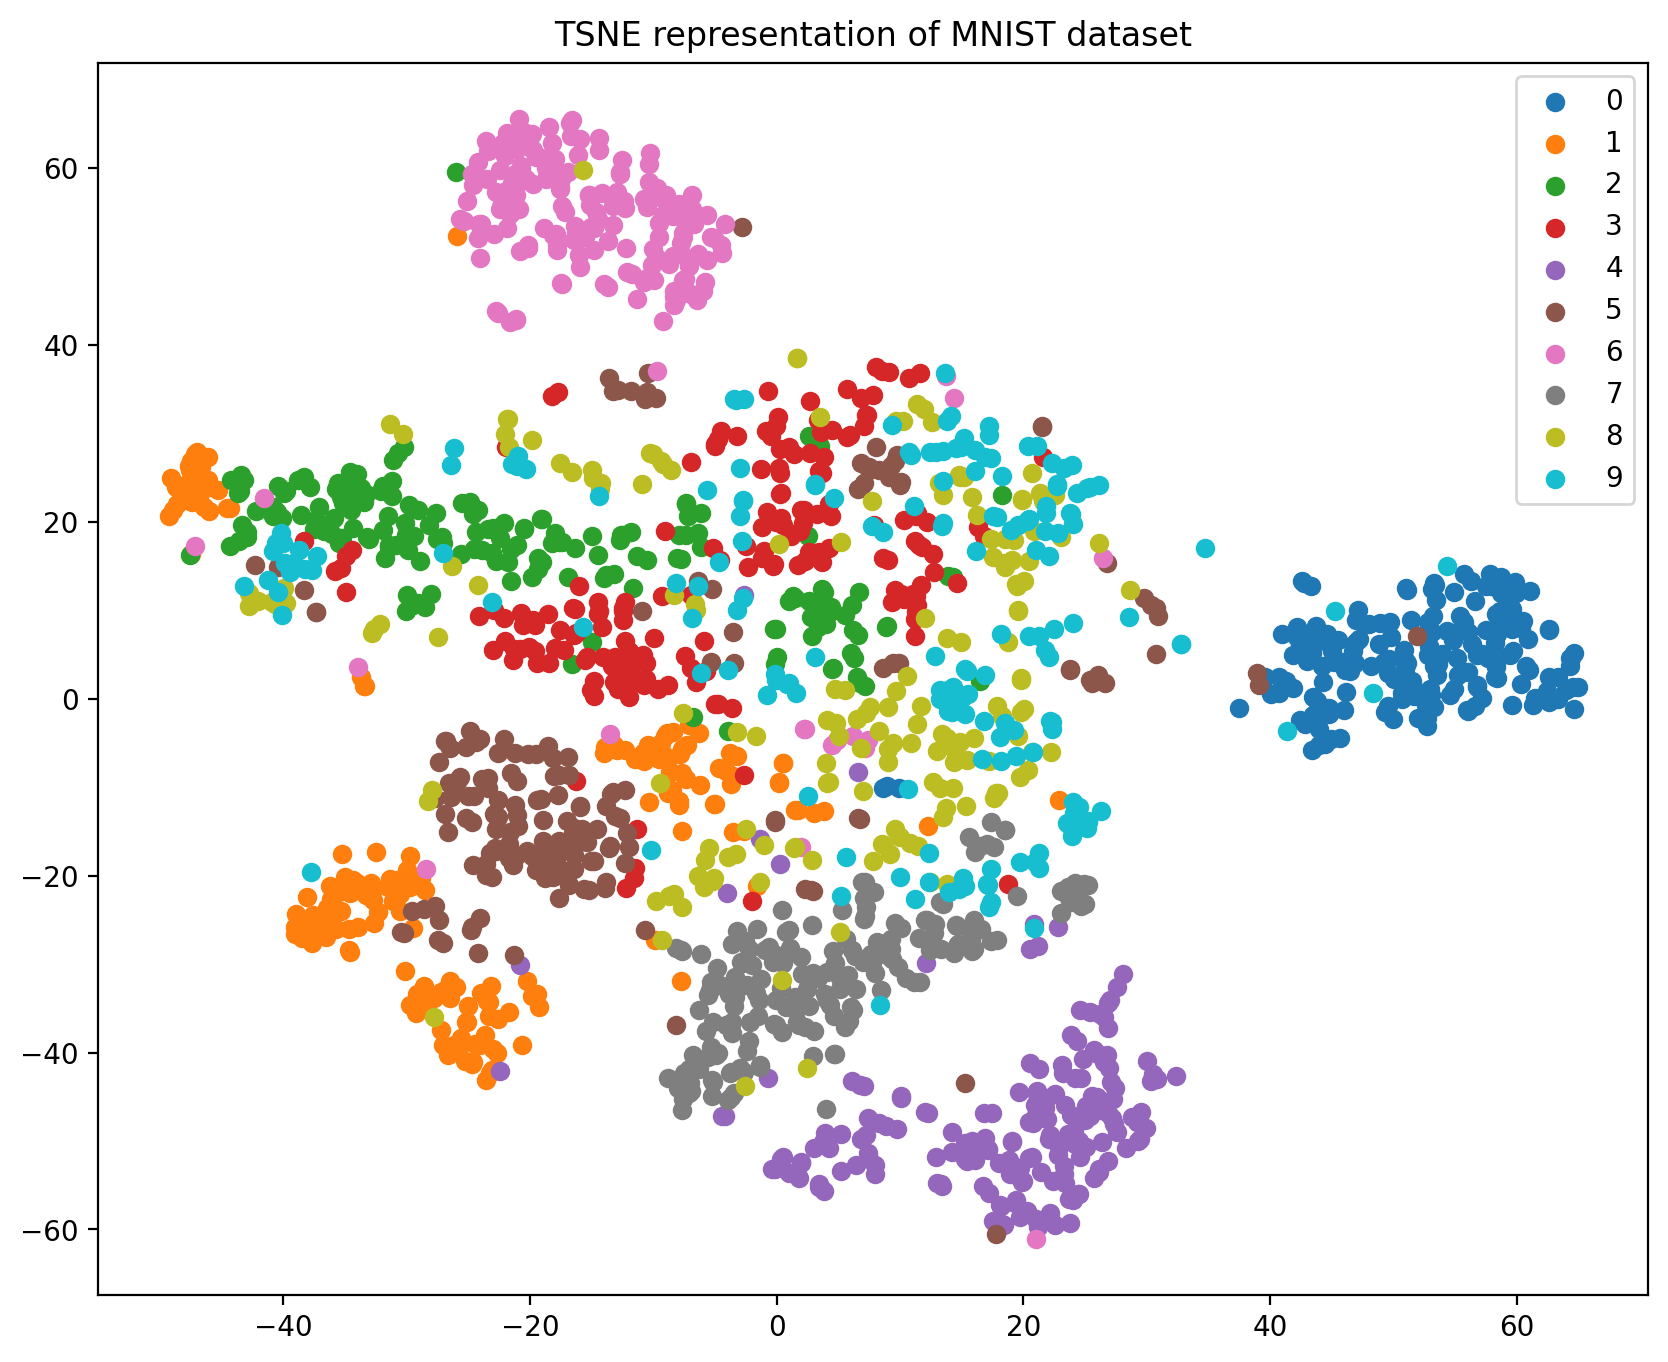

In [ ]:
model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
ptsne(data, model)

We observe the class separation between the different labels in a clear and interpretable manner. At a first glance, 4s, 0s, 6s and 5s have better separation, as they can be seen in clear clusters rather than in the tangled space close to the middle. The separation appears to be clearly worse for 3s, 9s, 2s, 8s.

If we recall the example of 5s and no 5s, this graph supports our conclusion, since there a higher percentage of instances of 5s in the regions that would correspond to non-5s than the other way around.

---
Now the next interesting idea to properly understand our results we applied stems from decomposing the images depending on their class.
What we propose is, for all images, consider the following decomposition for the $ith$ image of a class $c$.

\begin{align}
    im = \mu_c + \epsilon_i
\end{align}


where $\mu_c$ is a deterministic component linked to some class (it is the kmeans centroid assuming the algorithm converged perfectly, we could reuse the embeddings for it), and an stochastic component $\epsilon_i$ linked to each sample within a class. Analyzing this decomposition we can get a better idea of the differences on intraclass distribution between for examples 5s and not 5s, or any other pairs of distributions for that matter

In [ ]:
def decompdata(data, labels, target_label):
    # Filter data and labels for the specified target_label
    target_data = data[labels == target_label]

    # Calculate the mean image for the target class
    mean_image = np.mean(target_data, axis=0)

    # Calculate the noise distribution for the target class
    noise_distribution = target_data - mean_image

    return mean_image, noise_distribution

def decomprest(data, labels, target_label):
    non_target_indices = np.where(labels != target_label)[0]
    non_target_data = data[non_target_indices]
    mean_image = np.mean(non_target_data, axis=0)
    noise_distribution = non_target_data - mean_image
    return mean_image, noise_distribution

# for simple 1d analysis of distribution, considering the mean absolute noise
def flattenNoise(ndis):
  return np.mean(np.abs(ndis), axis=1)

In [ ]:
# auxiliary function for plotting the noise distribution of some label
def pnoise(noise_distribution, target_label):
  plt.figure(figsize=(12, 3))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(noise_distribution[i].reshape(8, 8), cmap='gray')
      plt.title(f'Noise {i + 1}')
      plt.axis('off')
  plt.suptitle(f'Noise Distribution for Class {target_label}')
  plt.show()

In [ ]:
# decomposing data assuming + class = 5s, - = everything else
target_label = 5
mean1, noise1 = decompdata(data.data, data.target, target_label)
mean2, noise2 = decomprest(data.data, data.target, target_label)

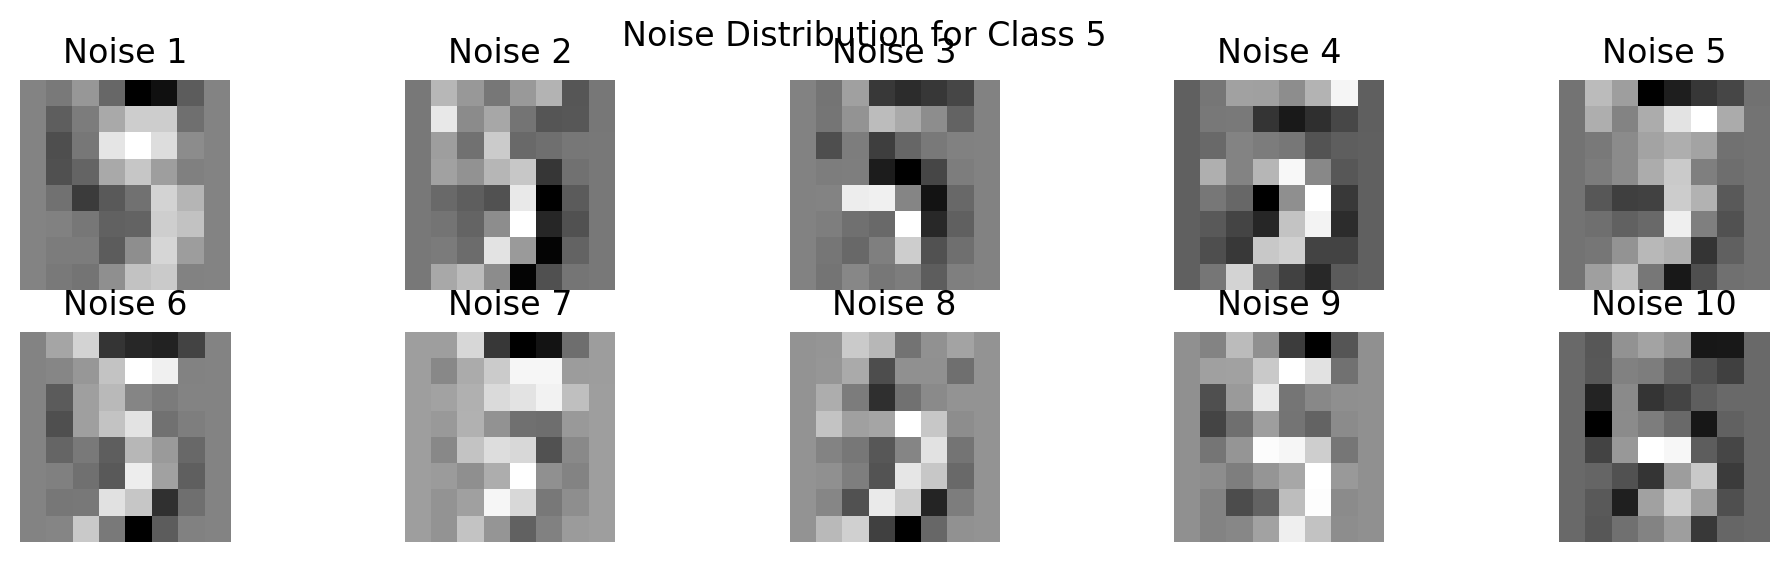

In [ ]:
# plotting noise distribution of 5 class
pnoise(noise1, target_label)

Now, as we seek to provide a graphical way to view the different in distributions, we use kernel density estimation to approximate the density functions of noise distributions, focussing on the case of 5s vs non-5s.

In [ ]:
from sklearn.neighbors import KernelDensity

flattendis1 = flattenNoise(noise1)
flattendis2 = flattenNoise(noise2)
kde1 = KernelDensity(bandwidth=0.2).fit(flattendis1.reshape(-1,1))
kde2 = KernelDensity(bandwidth=0.2).fit(flattendis2.reshape(-1,1))

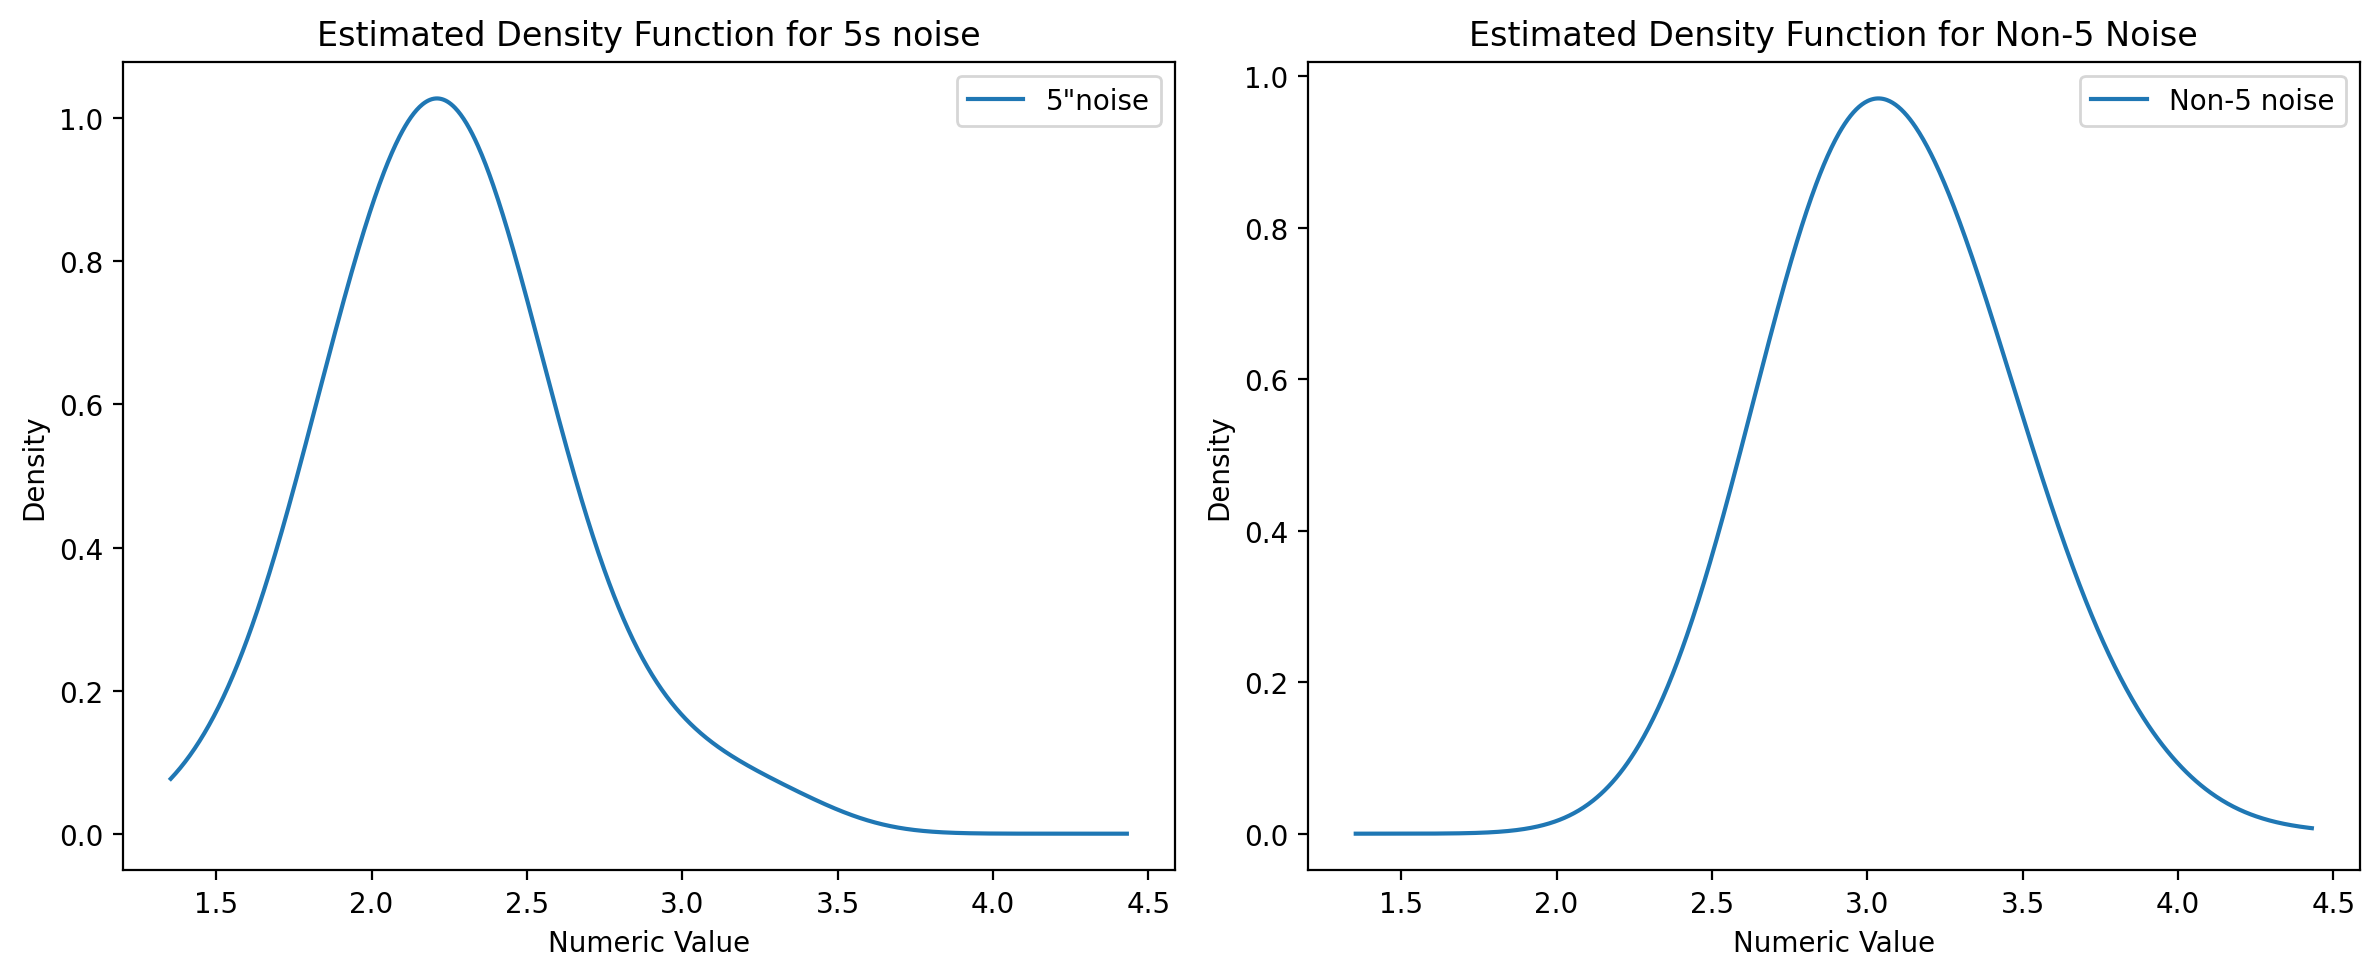

In [ ]:
# Generate data points for density estimation
x = np.linspace(min(np.min(flattendis1), np.min(flattendis2)),
                max(np.max(flattendis1), np.max(flattendis2)), 1000)
log_density_1 = kde1.score_samples(x.reshape(-1, 1))
log_density_2 = kde2.score_samples(x.reshape(-1, 1))

# Plot the estimated density functions side by side
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, np.exp(log_density_1), label='5"noise')
plt.title('Estimated Density Function for 5s noise')
plt.xlabel('Numeric Value')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, np.exp(log_density_2), label='Non-5 noise')
plt.title('Estimated Density Function for Non-5 Noise')
plt.xlabel('Numeric Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

Observing the density functions we can clearly see a big difference in the distributions with the one for 5s having fatter tails, thus it makes sense that if a bigger percentage of samples is distributed among a wider range of noise, this affects negatively our one class SVM as one distribution is harder to learn than the other.

We can integrate numerically the KDEs to observe the exact quantities.

In [ ]:
from scipy.integrate import quad

def integrate(kde, a, b):
  integrand = lambda x: np.exp(kde.score_samples(np.array(x).reshape(-1,1)))
  res, _ = quad(integrand, a, b)
  return res

With this numerical integration function we can illustrate as an example how the range of $[2, 4]$ in the first density function 'contains' less probability than a range of $[2.5, 3.5]$ in the second kde.

In [ ]:
integrate(kde1, 2, 4)

0.7231177106672786

In [ ]:
integrate(kde2,2.5, 3.5)

0.7726459108027866